In [8]:
# still incomplete!
import numpy as np
import numpy.linalg as lin
from scipy.integrate import ode
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy.random as ran
import time
import warnings
warnings.filterwarnings("ignore")
from matplotlib import rcParams
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.family': 'sans-serif',
         'text.usetex': True}
rcParams.update(params)
%matplotlib notebook

In [66]:
class disc_cont_model:
    
    def __init__(self,L,N,dt,init_rho,init_agents,tmax):
        self.L = L
        self.N = N
        self.dt = dt
        #self.W11 = W11
        self.dx = L/N
        self.dy = L/N
        self.tmax = tmax
        self.chalf_x = np.linspace(-L,L,int(2*N+1))
        self.cspan_x = np.linspace(-L + self.dx/2, L - self.dx/2, int(2*N))
        self.chalf_y = np.linspace(-L,L,int(2*N+1))
        self.cspan_y = np.linspace(-L + self.dy/2, L - self.dy/2, int(2*N))
        self.X, self.Y = np.meshgrid(self.cspan_x,self.cspan_y)
        self.rho = [init_rho]
        self.agents = [init_agents]
        self.rho_ex = [np.concatenate([x for x in init_rho])]
        self.s = 1.5
        self.Fr = 1
        self.Rr = 20
        self.Ra = 60
        self.Fa21 = 0.0038
        self.Fa12 = 0.203
        self.Fa22 = 0.00025
        self.kint_dens = int(self.Ra/self.dx + .5)
        self.M = int(2*self.L/self.Ra-.5)
        self.dbox = 2*self.L/self.M
        #self.W_mat = np.array([[W(x-self.X,y-self.Y) for x in self.cspan_x] for y in self.cspan_y])
        
    def boxnum_agents(self,x):
        x1, x2 = x[0] + self.L, x[1] + self.L
        i = max([min([self.M - 1, int(x1/self.dbox)]),0])
        j = max([min([self.M - 1, int(x2/self.dbox)]),0])
        return i,j
    
    def boxnum_dens(self,x):
        x1, x2 = x[0] + self.L, x[1] + self.L
        i = max([min([2*self.N - 1, int(x1/self.dx)]),0])
        j = max([min([2*self.N - 1, int(x2/self.dx)]),0])
        return i,j
    
    def H21(self,x1,x2):
        x = np.array([x1,x2])
        h1 = -self.Fr*(self.Rr/2)**(3-2*self.s)*lin.norm(x)**(2*self.s-3)*(lin.norm(x) < self.Rr/2)
        h2 = (2*self.Fr*(lin.norm(x)-self.Rr)/self.Rr)*(lin.norm(x) < self.Rr)*(lin.norm(x) >= self.Rr/2)
        h3 = -4*self.Fa21*(lin.norm(x)-self.Rr)*(lin.norm(x)-self.Ra)*x/lin.norm(x)/(self.Rr - self.Ra)**2*(lin.norm(x) < self.Ra)*(lin.norm(x) > self.Rr)
        return (h1 + h2 + h3)*x/lin.norm(x)
    
    def H22(self,x1,x2):
        x = np.array([x1,x2])
        h1 = -self.Fr*(self.Rr/2)**(3-2*self.s)*lin.norm(x)**(2*self.s-3)*(lin.norm(x) < self.Rr/2)
        h2 = (2*self.Fr*(lin.norm(x)-self.Rr)/self.Rr)*(lin.norm(x) < self.Rr)*(lin.norm(x) >= self.Rr/2)
        h3 = -4*self.Fa22*(lin.norm(x)-self.Rr)*(lin.norm(x)-self.Ra)*x/lin.norm(x)/(self.Rr - self.Ra)**2*(lin.norm(x) < self.Ra)*(lin.norm(x) > self.Rr)
        return (h1 + h2 + h3)*x/lin.norm(x)
    
    def W12(self,x1,x2):
        x = np.array([x1,x2])
        C1 = self.Fr*self.Rr*self.s/4/(self.s - 1)-2/3*self.Fa12*(self.Ra-self.Rr)
        C2 = self.Fr*self.Rr - 2/3*self.Fa12*(self.Ra - self.Rr)
        C3 = 2*self.Fa12*self.Ra**2*(3*self.Rr-self.Ra)/3/(self.Ra-self.Rr)**2
        h1 = (-self.Fr/2*(self.Rr/2)**(3-2*self.s)*lin.norm(x)**(2*self.s-2)/(self.s - 1) + C1)*(lin.norm(x) < self.Rr/2)
        h2 = (self.Fr/self.Rr*lin.norm(x)**2 - 2*self.Fr*lin.norm(x) + C2)*(lin.norm(x) < self.Rr)*(lin.norm(x) >= self.Rr/2)
        h3 = (-4*self.Fa12*(lin.norm(x)**3/3-lin.norm(x)**2/2*(self.Rr+self.Ra) + self.Ra*self.Rr*lin.norm(x))/(self.Rr - self.Ra)**2 + C3)*(lin.norm(x) < self.Ra)*(lin.norm(x) >= self.Rr)
        return h1 + h2 + h3
    
    def splitter(self,rho_expanded):
        return np.array(np.split(rho_expanded,2*self.N))
    
    def disc_entropy(self,f):
        return f  #+ np.array([[np.sum(np.multiply(w,f)) for w in ww] for ww in self.W_mat])*self.dx*self.dy
    
    def velocities_x(self,h):
        return -(h[1:,:]-h[:-1,:])/self.dx
    
    def velocities_y(self,h):
        return -(h[:,1:]-h[:,:-1])/self.dy
    
    def flux_x(self,v,g):
        zero_vec = np.zeros(v.shape)
        F = g[:-1,:]*np.maximum(v,zero_vec) + g[1:,:]*np.minimum(v,zero_vec)
        #F = (g[:-1,:] + g[1:,:])/2*v
        return np.concatenate([[np.zeros(len(F[0]))],F,[np.zeros(len(F[0]))]])
    
    def flux_y(self,v,g):
        zero_vec = np.zeros(v.shape)
        F = g[:,:-1]*np.maximum(v,zero_vec) + g[:,1:]*np.minimum(v,zero_vec)
        #F = (g[:,:-1] + g[:,1:])/2*v
        return np.transpose(np.concatenate([[np.zeros(len(F))],np.transpose(F),[np.zeros(len(F))]]))
    
    def grad_rho(self,t,p_expanded):
        p = self.splitter(p_expanded)
        h = self.disc_entropy(p)
        Fx = self.flux_x(self.velocities_x(h),p)
        Fy = self.flux_y(self.velocities_y(h),p)
        diff = -(Fx[1:,:]-Fx[:-1,:])/self.dx-(Fy[:,1:]-Fy[:,:-1])/self.dy 
        return np.concatenate([x for x in diff])*1000
    
    def grad_agents(self):
        ag = self.agents[-1]
        new = []
        boxes = [[[] for i in range(self.M)] for j in range(self.M)]
        for k in range(len(ag)):
            i,j = self.boxnum_agents(ag[k])
            boxes[i][j].append(k)
        for k in range(len(ag)):
            x = ag[k]
            i1,j1 = self.boxnum_dens(x)
            imin, imax = max(i1 - self.kint_dens, 0), min(2*self.N - 1, i1 + self.kint_dens) + 1
            jmin, jmax = max(j1 - self.kint_dens, 0), min(2*self.N - 1, j1 + self.kint_dens) + 1
            rho_int = self.rho[-1][jmin:jmax,imin:imax]
            W_conv = np.array([[self.H21(self.cspan_x[i] - x[0],self.cspan_y[j] - x[1]) if i!=i1 or j!=j1 else [0,0] for i in range(imin,imax)] for j in range(jmin,jmax)]) # reduced interaction kernel
            dx = np.array([np.sum(np.multiply(W_conv[:,:,0],rho_int)),np.sum(np.multiply(W_conv[:,:,1],rho_int))])*self.dx**2*self.dt
            
            i1,j1 = self.boxnum_agents(x)
            ind = np.concatenate([boxes[i1 + i][j1 + j] for i in range(-1,2) for j in range(-1, 2) 
                                  if i1 + i >= 0 and i1 + i < self.M and j1 + j >= 0 and j1 + j < self.M])
            ind = np.array([int(j) for j in ind if ag[int(j)][0] != x[0] or ag[int(j)][1] != x[1]])
            dx += np.sum([self.H22(ag[j][0] - x[0],ag[j][1] - x[1]) for j in ind], axis = 0)*self.dt
            
            #plt.imshow(W_conv[:,:,0],vmin = -1,vmax = 1)
            #plt.colorbar()
            #plt.show()
            if x[0] + dx[0] > self.L or x[0] + dx[0] < -self.L:
                dx[0] = - dx[0]
            if x[1] + dx[1] > self.L or x[1] + dx[1] < -self.L:
                dx[1] = - dx[1]
            new.append(x + dx)
        self.agents.append(new)  
    
    
    def solve(self):
        solODE = ode(self.grad_rho).set_integrator('dopri5')
        solODE.set_initial_value(self.rho_ex[0],0)
        t = 0
        while t < self.tmax:
            print('t = %.2f'% t,end = '\r')
            t += self.dt
            self.grad_agents()
            self.rho.append(self.splitter(solODE.integrate(t)))
        return np.array(self.rho), np.array(self.agents)

In [69]:
L = 400
N = 50
dx = L/N
dy = dx
dt = 10
tmax = 10000
xspan = np.linspace(-L + dx/2, L - dx/2, int(2*N))
yspan = np.linspace(-L + dy/2, L - dy/2, int(2*N))
init_rho = np.array([[100/np.pi/100**2 if abs(x + L - 100) < 100 and abs(y) < 100 else 0 for x in xspan] for y in yspan])
init_agents = [[-400 + 200,0], [-400 + 200,30], [-400 + 200,-30],[-400 + 200,60],[-400 + 200,-60]]


solver = disc_cont_model(L,N,dt,init_rho,init_agents,tmax)
rho_sol, agents_sol = solver.solve()

In [33]:
solver.boxnum_agents([-300,200])

(1, 9)

<IPython.core.display.Javascript object>


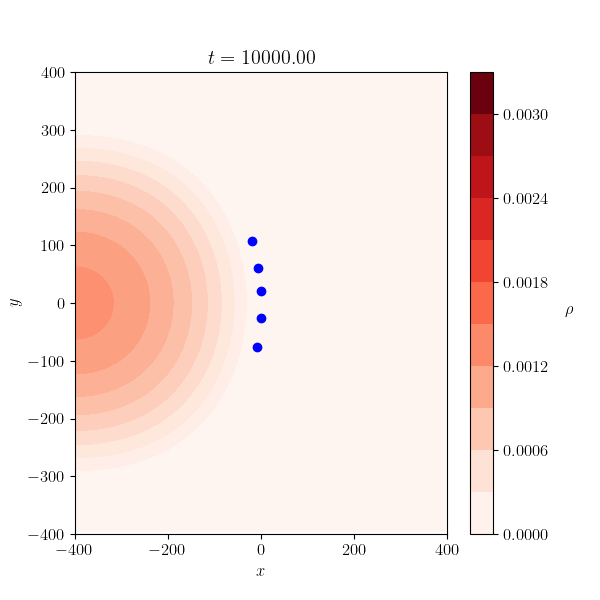

In [78]:
krem = 5
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%krem == 0]
agents = [agents_sol[i] for i in range(len(agents_sol)) if i%krem == 0]
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
ax.set_xlim(-L,L)
ax.set_ylim(-L,L)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
fig.canvas.draw()
ncont = 10
X,Y = solver.X, solver.Y
tspan = np.linspace(0,tmax,len(rho))
sc = ax.contourf(X,Y,rho[0],ncont,cmap = 'Reds',vmin = 1e-4,vmax = np.max(rho[0]))
cb = fig.colorbar(sc,ax = ax)
cb.set_label('$\\rho$',rotation = 0,labelpad = 15)
for y in agents[0]:
    ax.scatter(y[0],y[1], color = 'Blue')
for i in range(len(rho)):
    ax.contourf(X,Y,rho[i],ncont,cmap = 'Reds',vmin = 1e-4,vmax = np.max(rho[0]))
    ax.set_title('$t = %.2f$' % tspan[i])
    for y in agents[i]:
        ax.scatter(y[0],y[1], color = 'Blue')
    fig.canvas.draw()
    if i == 0:
        time.sleep(2)
    del ax.collections[:]
    del ax.lines[:]
ax.contourf(X,Y,rho[-1],ncont,cmap = 'Reds',vmin = 1e-4,vmax = np.max(rho[0]))
for y in agents[i]:
    ax.scatter(y[0],y[1], color = 'Blue')
plt.show()

In [81]:
solver.boxnum_dens(solver.agents[0][0])

(62, 49)

In [9]:
x = self.agents[0][0]
i1,j1 = self.boxnum_dens(x)
imin, imax = max(i1 - self.kint_dens, 0), min(2*self.N - 1, i1 + self.kint_dens) + 1
jmin, jmax = max(j1 - self.kint_dens, 0), min(2*self.N - 1, j1 + self.kint_dens) + 1
rho_int = self.rho[-1][jmin:jmax,imin:imax]
W_conv = np.array([[self.H21(self.cspan_x[i] - x[0],self.cspan_y[j] - x[1]) if i!=i1 or j!=j1 else [0,0] for i in range(imin,imax)] for j in range(jmin,jmax)]) # reduced interaction kernel
dx = np.array([np.sum(np.multiply(W_conv[:,:,0],rho_int)),np.sum(np.multiply(W_conv[:,:,1],rho_int))])*self.dx**2*self.dt

(7, 7)

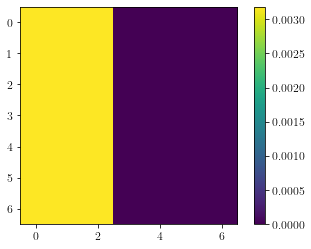

In [10]:
plt.imshow(rho_int)
plt.colorbar()
rho_int.shape

In [8]:
rho_int

array([[0.0031831, 0.0031831, 0.0031831, 0.0031831, 0.0031831, 0.0031831,
        0.0031831],
       [0.0031831, 0.0031831, 0.0031831, 0.0031831, 0.0031831, 0.0031831,
        0.0031831],
       [0.0031831, 0.0031831, 0.0031831, 0.0031831, 0.0031831, 0.0031831,
        0.0031831],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ]])

<ipython-input-269-3939ccc7bb7e>:19: RuntimeWarning: invalid value encountered in true_divide
  h2 = (2*Fr/Rr*lin.norm(x) - 2*Fr)*x/lin.norm(x)*(lin.norm(x) < Rr)*(lin.norm(x) >= Rr/2)
<ipython-input-269-3939ccc7bb7e>:20: RuntimeWarning: invalid value encountered in true_divide
  h3 = -4*Fa*(lin.norm(x)-Rr)*(lin.norm(x)-Ra)*x/lin.norm(x)/(Rr-Ra)**2*(lin.norm(x) < Ra)*(lin.norm(x) > Rr)


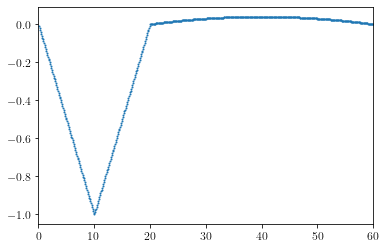

In [277]:
H = [H21(0,i)[1] for i in np.linspace(0,100,1000)]
plt.scatter(np.linspace(0,100,1000), H, s = 1)
plt.xlim(0,60)
plt.show()

In [260]:
agents

array([[[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,   0.]],

       [[120.,  

In [108]:
a = np.array([[1,2,3,4],[3,46,2,3]])
a[1:3,1:3] = [3,4]

In [109]:
a

array([[1, 2, 3, 4],
       [3, 3, 4, 3]])